<a href="https://colab.research.google.com/github/itberrios/CV_tracking/blob/main/setup_tutorials/midas_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Depth estimation with MiDaS!**

We will learn how to use [MiDaS_v2](https://arxiv.org/pdf/1907.01341.pdf) to estimate depth on a single image. We will then run this on an entire YouTube video. Let's get started, first install and import libraries


In [1]:
!pip install timm
!pip install pytube
!pip install moviepy
!pip install ffmpeg

# bug fix for imageio-ffmpeg
!pip install imageio==2.4.1

  Using cached imageio-2.31.5-py3-none-any.whl (313 kB)
  Attempting uninstall: imageio
    Found existing installation: imageio 2.4.1
    Uninstalling imageio-2.4.1:
      Successfully uninstalled imageio-2.4.1
  Using cached imageio-2.4.1-py3-none-any.whl
  Attempting uninstall: imageio
    Found existing installation: imageio 2.31.5
    Uninstalling imageio-2.31.5:
      Successfully uninstalled imageio-2.31.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
moviepy 1.0.3 requires imageio<3.0,>=2.5; python_version >= "3.4", but you have imageio 2.4.1 which is incompatible.


In [2]:
import os
import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["figure.figsize"] = (20, 10)

## **Get YouTube Video**

Copy and paste any YouTube url and and run the cell to download

In [3]:
from pytube import YouTube

video_url = r'https://www.youtube.com/watch?v=GAB89kDzCNA&pp=ygUPc2t5IGRpdmluZyBjbGlw'
yt = YouTube(video_url)
print("Video Title: ", yt.title)

# download video
video_path = yt.streams \
  .filter(progressive=True, file_extension='mp4') \
  .order_by('resolution') \
  .desc() \
  .first() \
  .download()

Video Title:  Ultimate Skydiving Compilation | People Are Awesome


### **Get Audio from video**

In [4]:
from moviepy.editor import VideoFileClip

video_path = "Ultimate Skydiving Compilation  People Are Awesome.mp4"
videoclip = VideoFileClip(video_path)
audioclip = videoclip.audio

In [5]:
video_fps = videoclip.fps
video_fps

25.0

## **Get MiDaS Model**

In [6]:
model_type = "DPT_Large"     # MiDaS v3 - Large     (highest accuracy, slowest inference speed)
# model_type = "DPT_Hybrid"   # MiDaS v3 - Hybrid    (medium accuracy, medium inference speed)
# model_type = "MiDaS_small"  # MiDaS v2.1 - Small   (lowest accuracy, highest inference speed)

midas = torch.hub.load("intel-isl/MiDaS", model_type)


Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


In [7]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)
midas.eval();

### Get MiDaS transforms

In [8]:
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


## **Inference function**

In [9]:
def inference(image, model=midas, transform=transform, device=device):
    input_batch = transform(image).to(device)
    with torch.no_grad():
        prediction = midas(input_batch)

        prediction = torch.nn.functional.interpolate(
            prediction.unsqueeze(1),
            size=image.shape[:2],
            mode="bicubic",
            align_corners=False,
        ).squeeze()

    return prediction.cpu().numpy()


In [10]:
import urllib.request

import matplotlib.pyplot as plt

url, filename = ("https://github.com/pytorch/hub/raw/master/images/dog.jpg", "dog.jpg")
urllib.request.urlretrieve(url, filename)

('dog.jpg', <http.client.HTTPMessage at 0x7d0435b24f10>)

In [11]:
img = cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB)

In [70]:
prediction = inference(img)

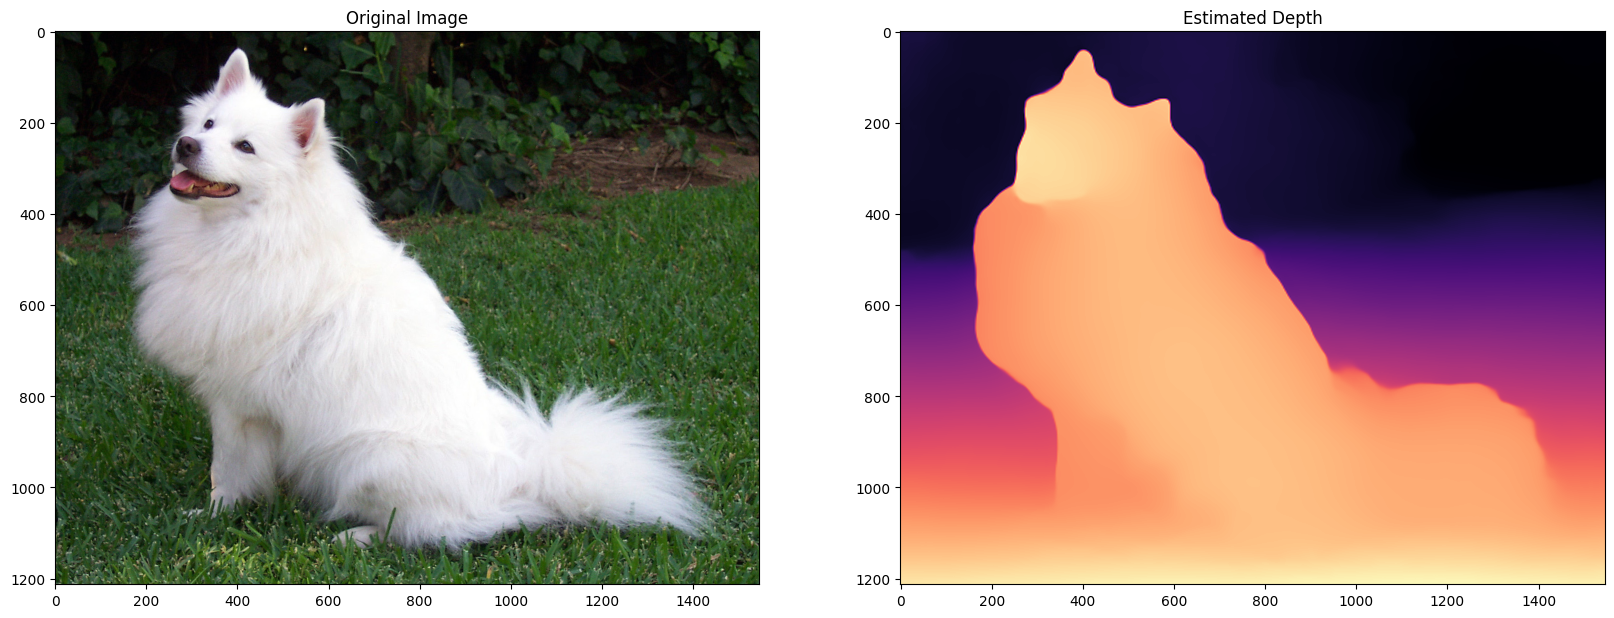

In [71]:
_, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(img)
ax[0].set_title("Original Image")
ax[1].imshow(prediction, cmap='magma')
ax[1].set_title("Estimated Depth");

## **Add some photoeffects**

We won't go too crazy here, for now we will just add an alpha channel based on the estimated depth

In [72]:
pred = cv2.convertScaleAbs(prediction, dst=None, alpha=1, beta=0)

pred = cv2.normalize(prediction, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)

img2 = np.dstack((img.copy(), pred))
img2 = cv2.cvtColor(img2, cv2.COLOR_RGB2RGBA)

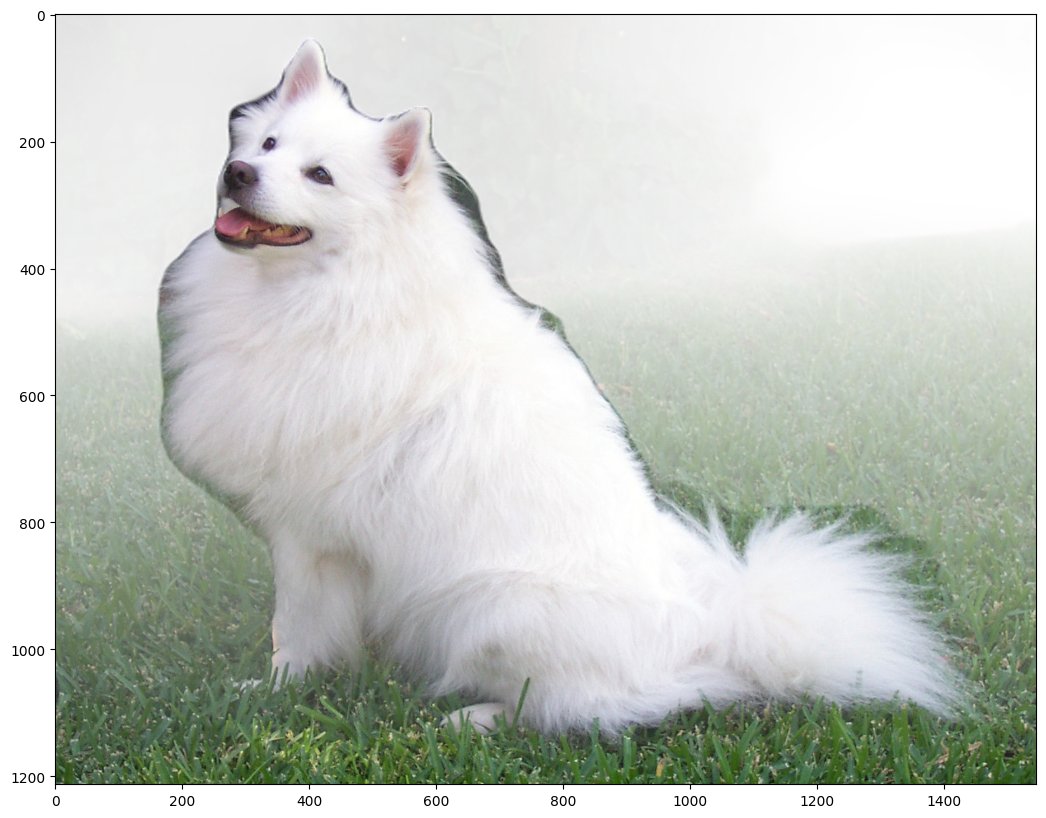

In [73]:
plt.imshow(img2)

## **Run Inference on video**

In [16]:
cap = cv2.VideoCapture(video_path)

if (cap.isOpened() == False):
    print("Error opening video file")

frames = []
predictions = []

i = 0
while(cap.isOpened()):

    # read each video frame
    ret, frame = cap.read()

    if ret == True:
        # get frame
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(image)

        # run inference
        prediction = inference(image)
        predictions.append(prediction)

        # stop early to avoid crashing colab
        if i > 1000:
            break

        i += 1

    # Break the loop
    else:
        break

# When everything done, release
# the video capture object
cap.release()

# Closes all the frames
cv2.destroyAllWindows()

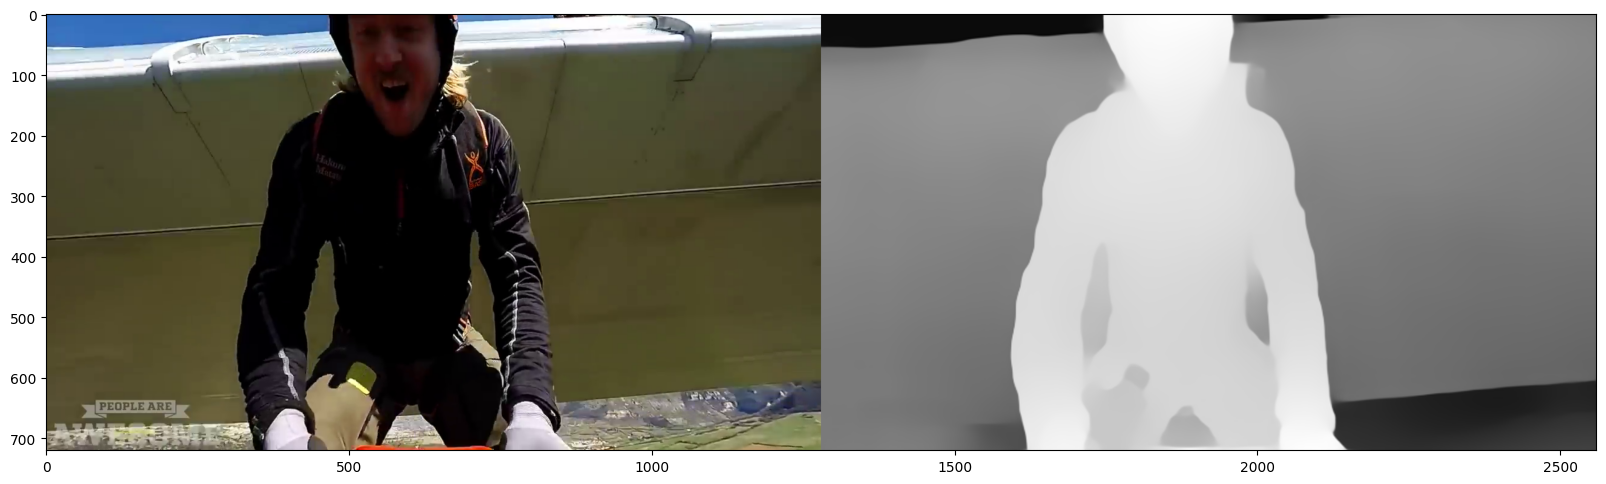

In [69]:
rgb_pred = cv2.normalize(predictions[-1], dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
# rbg_pred = rgb_pred[:, :, None].repeat(3, axis=-1)
stacked = np.hstack((frames[-1], rgb_pred[:, :, None].repeat(3, axis=-1)))

plt.imshow(stacked);

In [63]:
rgb_pred.shape

(720, 1280)

In [62]:
rgb_pred[:, :, None].repeat(3, axis=-1).shape

(720, 1280, 3)

## **Reconstruct Video with Audio**

In [66]:
video_length = len(frames)/video_fps

# trim audio file to length of video
audioclip_trimmed = audioclip.subclip(0, video_length)

In [74]:
# get width and height for video frames
h, w, _ = stacked.shape

# save to mp4
out = cv2.VideoWriter('Ultimate Skydiving Compilation  People Are Awesome_depth.mp4',
                      cv2.VideoWriter_fourcc(*'MP4V'),
                      video_fps,
                      (w, h))

for i in range(len(predictions)):
    frame = frames[i]
    pred = predictions[i]

    rgb_pred = cv2.normalize(pred, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
    stacked = np.hstack((frame, rgb_pred[:, :, None].repeat(3, axis=-1)))

    out.write(cv2.cvtColor(stacked, cv2.COLOR_RGB2BGR))
out.release()

In [75]:
from moviepy.editor import CompositeAudioClip
depth_video = VideoFileClip('Ultimate Skydiving Compilation  People Are Awesome_depth.mp4')
# audioclip = AudioFileClip("audioname.mp3")

new_audioclip = CompositeAudioClip([audioclip_trimmed])
depth_video.audio = new_audioclip
depth_video.write_videofile('Ultimate Skydiving Compilation  People Are Awesome_withAudio.mp4')

Moviepy - Building video Ultimate Skydiving Compilation  People Are Awesome_withAudio.mp4.
MoviePy - Writing audio in Ultimate Skydiving Compilation  People Are Awesome_withAudioTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video Ultimate Skydiving Compilation  People Are Awesome_withAudio.mp4



Moviepy - Done !
Moviepy - video ready Ultimate Skydiving Compilation  People Are Awesome_withAudio.mp4
